# 創生科学実験 C-3  第 1 回目



### (1) 事前準備

#### (1-0) GoogleDriveのマウント

In [ ]:
#自分のGoogle Drive をマウントする．
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### (1-1) 必要なライブラリのインポート

In [ ]:
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

gpu_device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu") # GPUを利用する

print("GPUが使えるかどうか：", torch.cuda.is_available())
print("GPUの数: ", torch.cuda.device_count())
print("GPU名:", torch.cuda.get_device_name())

criterion = nn.CrossEntropyLoss() # ロス関数を定義する

GPUが使えるかどうか： True
GPUの数:  1
GPU名: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### (1-2) 深層ニューラルネットのモデル

##### 1. MLP(マルチレイヤーパーセプトロン)


*   中間層 2層 $\times$ ニューロン 1024個

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_in=28*28, n_out=10):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(n_in, 1024)
        self.l2 = nn.Linear(1024, 1024)
        self.l3 = nn.Linear(1024, n_out)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, np.prod(x.size()[1:]))
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.l3(x)
        return x

##### 2. 小さなCNN(畳み込みニューラルネット)

In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, in_channel=1, mid1_channel=4, mid2_channel=16, n_mid=1024, n_out=10, height=28, width=28):
        super(SmallCNN, self).__init__()

        pixel = np.array([height, width])
        pixel = (pixel - 3) // 2 + 1 # 1番目のプーリング層通過後の画素数
        pixel = (pixel - 3) // 2 + 1 # 2番目のプーリング層通過後の画素数
        self.n_feature = mid2_channel * pixel[0] * pixel[1] # 1番目の全結合層のニューロン数

        self.conv1 = nn.Conv2d(in_channel, mid1_channel, 3, padding=1, stride=1, bias=False)
        self.bn1_conv = nn.BatchNorm2d(mid1_channel)
        self.conv2 = nn.Conv2d(mid1_channel, mid2_channel, 3, padding=1,stride=1,bias=False)
        self.bn2_conv = nn.BatchNorm2d(mid2_channel)
        self.fc1 = nn.Linear(self.n_feature, n_mid, bias=False)
        self.bn1_fc = nn.BatchNorm1d(n_mid)
        self.fc2 = nn.Linear(n_mid, n_mid, bias=False)
        self.bn2_fc = nn.BatchNorm1d(n_mid)
        self.fc3 = nn.Linear(n_mid, n_out, bias=False)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        h1 = self.maxpool(self.relu(self.bn1_conv(self.conv1(x))))
        h2 = self.maxpool(self.relu(self.bn2_conv(self.conv2(h1))))
        h2 = h2.view(-1, self.n_feature) # h2の出力である特徴量を１次元に変換する
        h3 = self.dropout(self.relu(self.bn1_fc(self.fc1(h2))))
        h4 = self.dropout(self.relu(self.bn2_fc(self.fc2(h3))))
        output = self.fc3(h4)
        return output

##### 3. AlexNet

2012年のILSVRC(画像認識のコンペティション)で優勝したトロント大学のチームのネットワーク

https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, in_channel=1, num_classes=10):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            #nn.Conv2d(in_channel, 64, kernel_size=11, stride=4, padding=2),
            nn.Conv2d(in_channel, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=3, stride=2),
            #nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        D=1 #もとは6
        self.avgpool = nn.AdaptiveAvgPool2d((D, D))
        # 上は入力画像のサイズを可変にするための処理． 例えばここで 3x4　や 11x11 とかになっていたとしても， DxDに変換する．
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * D * D, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#### (1-3) モデルを学習する関数
* learning(model)
* 戻り値はログのリスト

In [ ]:
def learning(dnn_model):
  num_epochs = 10

  optimizer = optim.Adam(dnn_model.parameters())

  #順に，訓練ロス, 訓練正解率，テストロス，テスト正解率
  log_list = [[], [], [], []]

  for epoch in range(num_epochs):
    # initialize each epoch
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
    # 訓練フェーズ
    dnn_model.train()#訓練モードにする
    for i, (images, labels) in enumerate(tqdm(trainloader)):  # バッチ回数実
      images = images.to(gpu_device)
      labels = labels.to(gpu_device)
      optimizer.zero_grad()  # 勾配リセット
      outputs = dnn_model(images)  # 順伝播の計算
      loss = criterion(outputs, labels)  # lossの計算
      train_loss += loss.item()  # train_loss に結果を蓄積
      acc = (outputs.max(1)[1] == labels).sum()  #  予測とラベルが合っている数の合計
      train_acc += acc.item()  # train_acc に結果を蓄積
      loss.backward()  # 逆伝播の計算
      optimizer.step()  # 重みの更新
      avg_train_loss = train_loss / len(trainloader.dataset)  # lossの平均を計算
      avg_train_acc = train_acc / len(trainloader.dataset)  # accの平均を計算
    # テストフェーズ
    dnn_model.eval()#検証(評価)モードにする
    with torch.no_grad():  # 必要のない計算を停止
      for i, (images, labels) in enumerate(testloader):
        images = images.to(gpu_device)
        labels = labels.to(gpu_device)
        outputs = dnn_model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        acc = (outputs.max(1)[1] == labels).sum()
        val_acc += acc.item()
    avg_val_loss = val_loss / len(testloader.dataset)
    avg_val_acc = val_acc / len(testloader.dataset)
    # print log
    print(f"[Epoch]: {epoch + 1}/{num_epochs}\t"
          f"[train_loss]: {avg_train_loss:.4f}\t[train_acc]: {avg_train_acc:.4f}\t"
          f"[val_loss]: {avg_val_loss:.4f}\t[val_acc]: {avg_val_acc:.4f}")
    # append list for plot graph after training
    log_list[0].append(avg_train_loss)
    log_list[1].append(avg_train_acc)
    log_list[2].append(avg_val_loss)
    log_list[3].append(avg_val_acc)

  return log_list

# 結果をグラフで表示する関数もついでに定義しておく．
def draw_graph(log_list):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
  num_epochs = len(log_list[0])
  ax1.plot(range(num_epochs), log_list[0], 'r-', label="train_loss")
  ax1.plot(range(num_epochs), log_list[2], 'b--', label="val_loss")
  ax1.legend()
  ax1.set_xlabel("epoch")
  ax1.set_ylabel("loss")
  ax1.set_title("Training and validation loss")
  ax1.grid()

  ax2.plot(range(num_epochs), log_list[1], 'r-', label="train_acc")
  ax2.plot(range(num_epochs), log_list[3], 'b--', label="val_acc")
  ax2.legend()
  ax2.set_xlabel("epoch")
  ax2.set_ylabel("acc")
  ax2.set_title("Training and validation accuracy")
  ax2.grid()

### (2) MNISTデータの取得


In [ ]:
transform = transforms.Compose([ transforms.ToTensor()]) #transforms.Grayscale(),
trainset = torchvision.datasets.MNIST(
    root="./mnist", train=True, download=True, transform=transform
)
testset = torchvision.datasets.MNIST(
    root="./mnist", train=False, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False
)

100%|██████████| 9912422/9912422 [00:00<00:00, 270805669.69it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 25142319.18it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 77511559.63it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22815004.51it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



#### (2-1) MNISTデータを表示してみる．
* 60,000枚の訓練データ． 10,000枚のテストデータ
* 28 x 28 サイズのグレースケール画像．

データの数(訓練，テスト): 60000 10000
画像の形状: (28, 28)
ラベル: 5


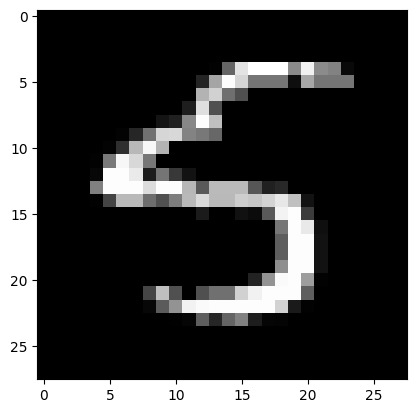

In [ ]:
print("データの数(訓練，テスト):", len(trainset), len(testset))
for (x,y) in trainloader:
  imgs = x[:1] # 訓練データから1個画像をとってくる．
  break
#grid = torchvision.utils.make_grid(imgs).cpu().numpy().transpose(1, 2, 0)
grid = imgs.squeeze().numpy()
print("画像の形状:", grid.shape)
print("ラベル:", y[0].numpy())
plt.imshow(grid,cmap="gray",vmin=0, vmax=1)

### (3) MNISTを使ったモデルの学習と訓練．


#### (3-1) MLP の場合

  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 1/10	[train_loss]: 0.0022	[train_acc]: 0.9343	[val_loss]: 0.0010	[val_acc]: 0.9667


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 2/10	[train_loss]: 0.0008	[train_acc]: 0.9749	[val_loss]: 0.0007	[val_acc]: 0.9750


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 3/10	[train_loss]: 0.0005	[train_acc]: 0.9836	[val_loss]: 0.0007	[val_acc]: 0.9785


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 4/10	[train_loss]: 0.0004	[train_acc]: 0.9875	[val_loss]: 0.0007	[val_acc]: 0.9789


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 5/10	[train_loss]: 0.0003	[train_acc]: 0.9909	[val_loss]: 0.0007	[val_acc]: 0.9803


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 6/10	[train_loss]: 0.0003	[train_acc]: 0.9917	[val_loss]: 0.0008	[val_acc]: 0.9796


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 7/10	[train_loss]: 0.0002	[train_acc]: 0.9926	[val_loss]: 0.0009	[val_acc]: 0.9776


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 8/10	[train_loss]: 0.0002	[train_acc]: 0.9937	[val_loss]: 0.0008	[val_acc]: 0.9820


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 9/10	[train_loss]: 0.0002	[train_acc]: 0.9934	[val_loss]: 0.0008	[val_acc]: 0.9816


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 10/10	[train_loss]: 0.0001	[train_acc]: 0.9958	[val_loss]: 0.0007	[val_acc]: 0.9843


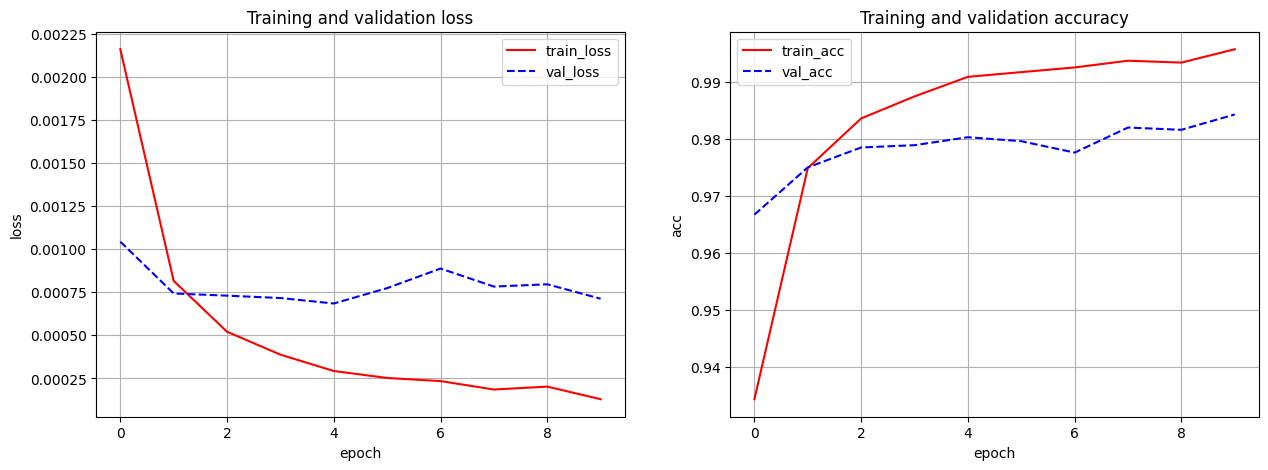

In [ ]:
model1 = MLP().to(gpu_device) #モデルの作成と初期化
log = learning(model1) # 訓練の実行
draw_graph(log) #学習曲線の描画

####  (3-2)  小さなCNN の場合

  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 1/10	[train_loss]: 0.0014	[train_acc]: 0.9572	[val_loss]: 0.0007	[val_acc]: 0.9775


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 2/10	[train_loss]: 0.0007	[train_acc]: 0.9779	[val_loss]: 0.0004	[val_acc]: 0.9855


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 3/10	[train_loss]: 0.0005	[train_acc]: 0.9824	[val_loss]: 0.0004	[val_acc]: 0.9872


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 4/10	[train_loss]: 0.0004	[train_acc]: 0.9858	[val_loss]: 0.0004	[val_acc]: 0.9866


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 5/10	[train_loss]: 0.0004	[train_acc]: 0.9870	[val_loss]: 0.0005	[val_acc]: 0.9864


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 6/10	[train_loss]: 0.0004	[train_acc]: 0.9881	[val_loss]: 0.0004	[val_acc]: 0.9870


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 7/10	[train_loss]: 0.0003	[train_acc]: 0.9895	[val_loss]: 0.0004	[val_acc]: 0.9881


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 8/10	[train_loss]: 0.0003	[train_acc]: 0.9899	[val_loss]: 0.0005	[val_acc]: 0.9860


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 9/10	[train_loss]: 0.0003	[train_acc]: 0.9907	[val_loss]: 0.0004	[val_acc]: 0.9897


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 10/10	[train_loss]: 0.0003	[train_acc]: 0.9919	[val_loss]: 0.0004	[val_acc]: 0.9898


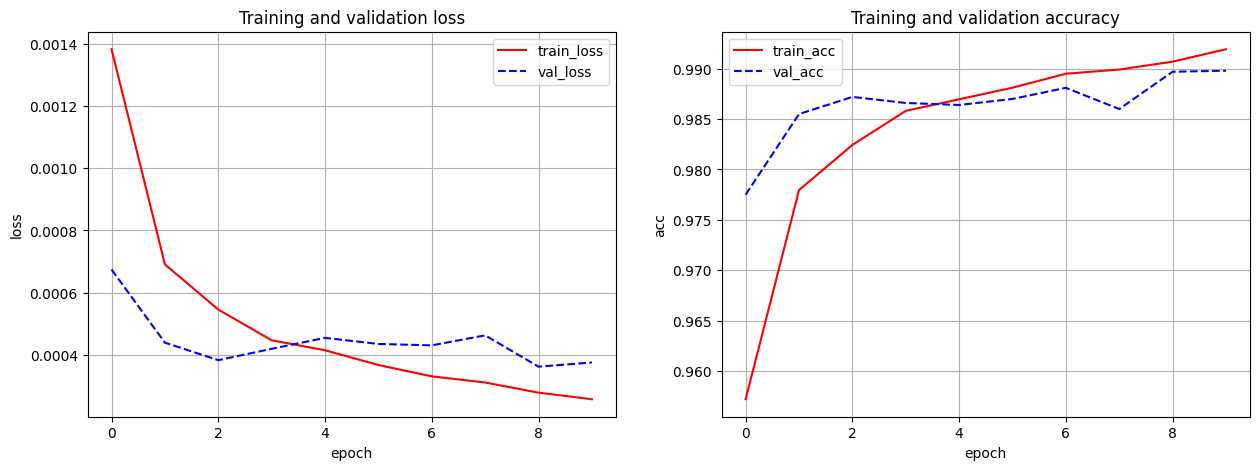

In [ ]:
model2 = SmallCNN().to(gpu_device) #モデルの作成と初期化
log = learning(model2) # 訓練の実行
draw_graph(log) #学習曲線の描画

####  (3-3)  AlexNet の場合
* 10分ぐらいかかるかもしれません．

  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 1/10	[train_loss]: 0.0091	[train_acc]: 0.6639	[val_loss]: 0.0012	[val_acc]: 0.9618


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 2/10	[train_loss]: 0.0015	[train_acc]: 0.9558	[val_loss]: 0.0006	[val_acc]: 0.9786


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 3/10	[train_loss]: 0.0010	[train_acc]: 0.9683	[val_loss]: 0.0005	[val_acc]: 0.9860


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 4/10	[train_loss]: 0.0008	[train_acc]: 0.9742	[val_loss]: 0.0005	[val_acc]: 0.9857


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 5/10	[train_loss]: 0.0007	[train_acc]: 0.9772	[val_loss]: 0.0003	[val_acc]: 0.9894


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 6/10	[train_loss]: 0.0007	[train_acc]: 0.9798	[val_loss]: 0.0003	[val_acc]: 0.9895


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 7/10	[train_loss]: 0.0006	[train_acc]: 0.9817	[val_loss]: 0.0003	[val_acc]: 0.9905


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 8/10	[train_loss]: 0.0006	[train_acc]: 0.9831	[val_loss]: 0.0004	[val_acc]: 0.9878


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 9/10	[train_loss]: 0.0005	[train_acc]: 0.9844	[val_loss]: 0.0003	[val_acc]: 0.9913


  0%|          | 0/600 [00:00<?, ?it/s]

[Epoch]: 10/10	[train_loss]: 0.0005	[train_acc]: 0.9856	[val_loss]: 0.0003	[val_acc]: 0.9897


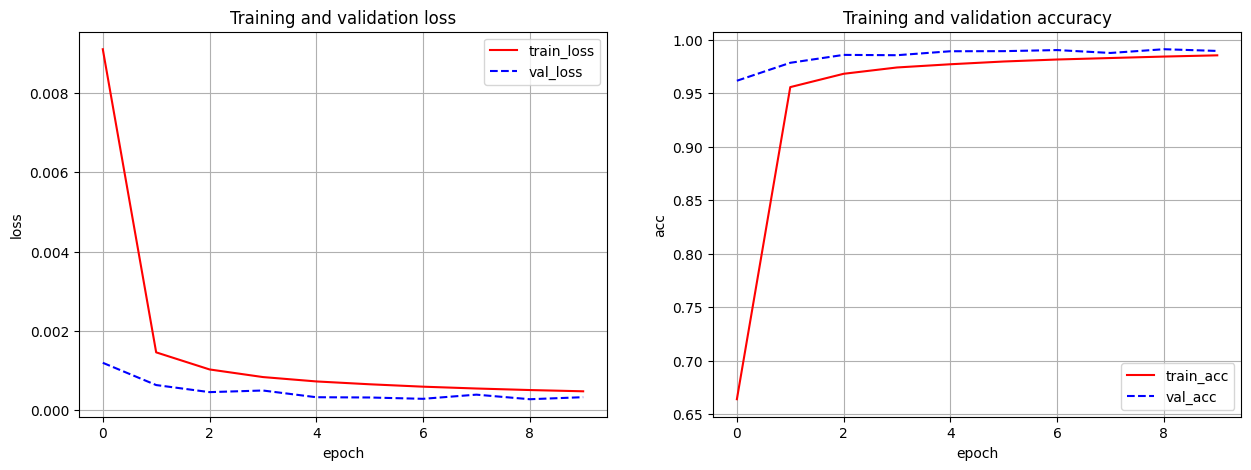

In [ ]:
model3 = AlexNet().to(gpu_device) #モデルの作成と初期化
log = learning(model3) # 訓練の実行
draw_graph(log) #学習曲線の描画

### (4) 自分で用意した画像を分類する．

(100, 100, 4)


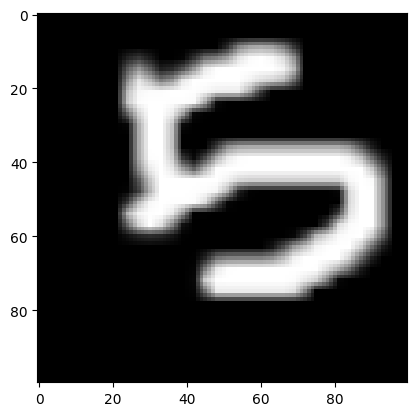

In [ ]:
#サンプルの画像を表示してみる．
my_dir = "drive/MyDrive/sosei_exp/sample_0-9"
img = plt.imread(my_dir+"/5/test.png")
print(img.shape)
plt.imshow(img)

####  (4-2) フォルダの画像を読み込む．
[注意] フォルダの中身を更新したときはこのセルを実行しなすこと．
* 画像の形式(png,jpegなど)は何でも良い．
* 読み込まれた画像は，グレースケール 28x28 にリサイズされる．
* 縦横の長さが違うときは，真ん中が正方形の形でクロップされる．


In [ ]:
transform = torchvision.transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(28),
        transforms.CenterCrop(28),
        transforms.ToTensor()
    ])
my_dataset = torchvision.datasets.ImageFolder(my_dir, transform=transform)
my_loader = torch.utils.data.DataLoader(my_dataset, batch_size=10)

####  (4-3) 読み込んだフォルダの画像に対して，モデルを適用する関数．

In [ ]:
#ImageFolder内のidから正しい数字(フォルダ名)への変換マップ
id_to_class = {i:int(c) for c, i in  my_dataset.class_to_idx.items()}
print(id_to_class)
def predict_my_dataset(dnn_model):
  dnn_model.eval()
  n_correct = 0
  n_all = len(my_loader.dataset)
  with torch.no_grad():
    for x, t in my_loader:
      x = x.to(gpu_device)
      outputs = dnn_model(x) # モデルでラベルを予測
      pred = outputs.max(1)[1].data.cpu().numpy()
      label = (t.data.numpy()) #ImageFolder内の正解ラベル
      label = np.array([id_to_class[i] for i in label] )#正しい数字へ変換
      n = (pred == label).sum() #正解した数
      n_correct += n
      print("正解ラベル:", label)
      print("予測ラベル:", pred, "正解数:", n)
      #画像の表示
      grid = torchvision.utils.make_grid(x, nrow=10, pad_value=1)
      grid_img = grid.data.cpu().numpy().transpose(1,2,0)
      plt.imshow(grid_img)
      plt.show()

  print(f"総正解ラベル数/総ラベル数 ={n_correct}/{n_all}")
  print(f"正解率 = {n_correct/n_all}")

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


#### (4-5) 学習済みのモデルで予測する．

##### MLP の場合

正解ラベル: [0 0 0 0 0 0 0 0 0 0]
予測ラベル: [0 0 0 0 0 0 0 0 0 9] 正解数: 9


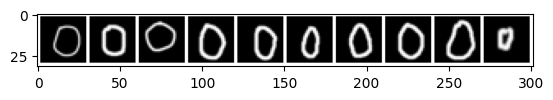

正解ラベル: [0 1 1 1 1 1 1 1 1 1]
予測ラベル: [0 1 1 1 1 1 1 1 1 1] 正解数: 10


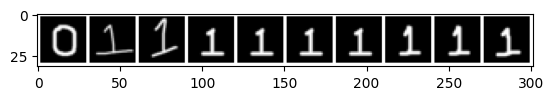

正解ラベル: [1 1 1 1 1 1 1 1 1 1]
予測ラベル: [1 1 1 1 1 3 3 5 5 2] 正解数: 5


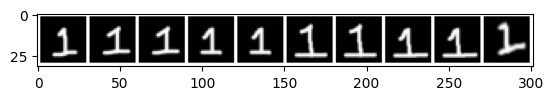

正解ラベル: [2 2 2 2 2 2 2 2 2 2]
予測ラベル: [2 2 2 2 2 2 2 2 2 2] 正解数: 10


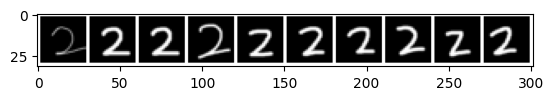

正解ラベル: [2 3 3 3 3 3 3 3 3 3]
予測ラベル: [2 3 3 3 3 3 3 3 3 3] 正解数: 10


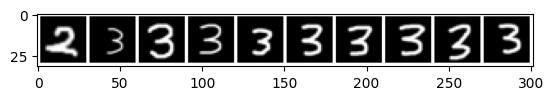

正解ラベル: [3 4 4 4 4 4 4 4 4 4]
予測ラベル: [3 4 4 8 4 6 4 4 4 4] 正解数: 8


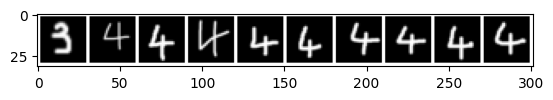

正解ラベル: [4 5 5 5 5 5 5 5 5 5]
予測ラベル: [4 5 5 5 5 5 5 5 5 5] 正解数: 10


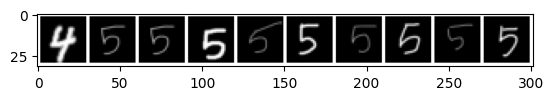

正解ラベル: [5 5 6 6 6 6 6 6 6 6]
予測ラベル: [5 6 6 6 5 6 6 6 6 7] 正解数: 7


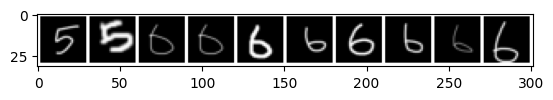

正解ラベル: [6 6 6 7 7 7 7 7 7 7]
予測ラベル: [6 5 6 7 7 7 7 7 2 9] 正解数: 7


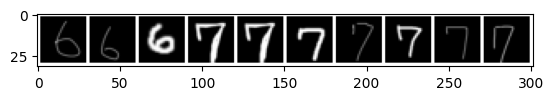

正解ラベル: [7 7 7 7 8 8 8 8 8 8]
予測ラベル: [8 5 7 7 8 8 8 8 3 8] 正解数: 7


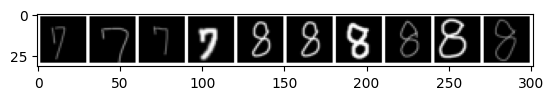

正解ラベル: [8 8 8 8 8 9 9 9 9 9]
予測ラベル: [8 8 8 8 8 8 8 2 8 9] 正解数: 6


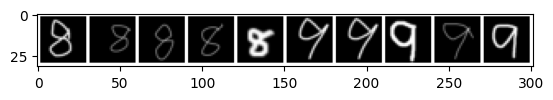

正解ラベル: [9 9 9 9 9 9]
予測ラベル: [3 8 2 9 9 9] 正解数: 3


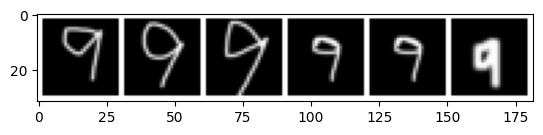

総正解ラベル数/総ラベル数 =92/116
正解率 = 0.7931034482758621


In [ ]:
predict_my_dataset(model1)

##### 小さなCNNの場合

正解ラベル: [0 0 0 0 0 0 0 0 0 0]
予測ラベル: [0 0 0 0 0 0 0 0 0 0] 正解数: 10


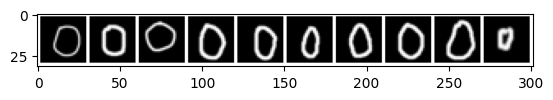

正解ラベル: [0 1 1 1 1 1 1 1 1 1]
予測ラベル: [0 1 1 1 1 1 1 1 1 1] 正解数: 10


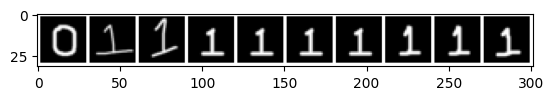

正解ラベル: [1 1 1 1 1 1 1 1 1 1]
予測ラベル: [1 1 1 1 1 1 1 1 1 2] 正解数: 9


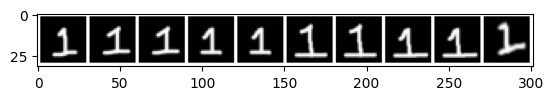

正解ラベル: [2 2 2 2 2 2 2 2 2 2]
予測ラベル: [1 2 2 2 2 2 2 2 2 2] 正解数: 9


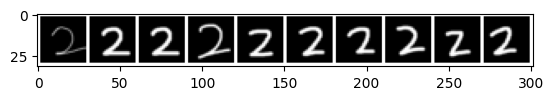

正解ラベル: [2 3 3 3 3 3 3 3 3 3]
予測ラベル: [2 3 3 3 3 3 3 3 3 3] 正解数: 10


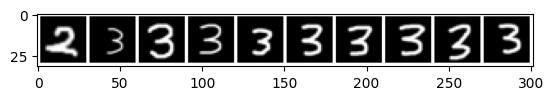

正解ラベル: [3 4 4 4 4 4 4 4 4 4]
予測ラベル: [3 4 4 4 4 4 4 4 4 4] 正解数: 10


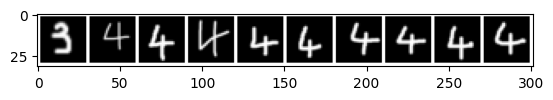

正解ラベル: [4 5 5 5 5 5 5 5 5 5]
予測ラベル: [4 5 5 5 5 5 1 5 1 5] 正解数: 8


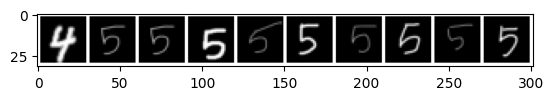

正解ラベル: [5 5 6 6 6 6 6 6 6 6]
予測ラベル: [5 5 1 1 6 6 6 6 1 6] 正解数: 7


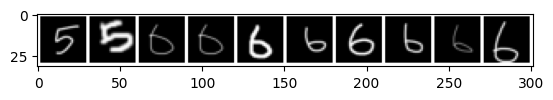

正解ラベル: [6 6 6 7 7 7 7 7 7 7]
予測ラベル: [1 1 6 7 7 7 1 7 1 1] 正解数: 5


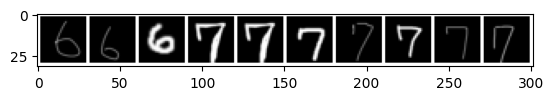

正解ラベル: [7 7 7 7 8 8 8 8 8 8]
予測ラベル: [1 7 1 7 8 8 8 8 3 1] 正解数: 6


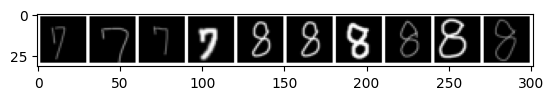

正解ラベル: [8 8 8 8 8 9 9 9 9 9]
予測ラベル: [8 1 1 1 8 9 9 9 1 9] 正解数: 6


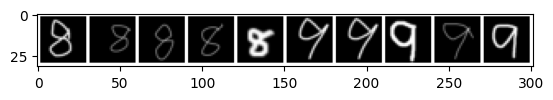

正解ラベル: [9 9 9 9 9 9]
予測ラベル: [4 9 7 9 9 9] 正解数: 4


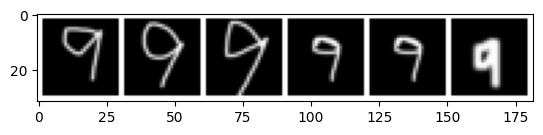

総正解ラベル数/総ラベル数 =94/116
正解率 = 0.8103448275862069


In [ ]:
predict_my_dataset(model2)

##### AlexNetの場合

正解ラベル: [0 0 0 0 0 0 0 0 0 0]
予測ラベル: [0 0 0 0 0 0 0 0 0 0] 正解数: 10


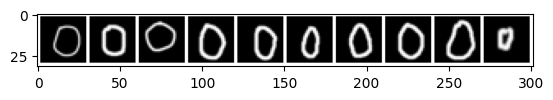

正解ラベル: [0 1 1 1 1 1 1 1 1 1]
予測ラベル: [0 1 1 1 1 1 1 1 1 1] 正解数: 10


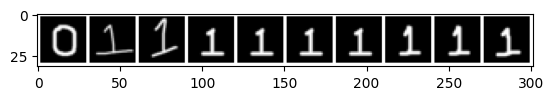

正解ラベル: [1 1 1 1 1 1 1 1 1 1]
予測ラベル: [1 1 1 1 1 1 1 1 1 2] 正解数: 9


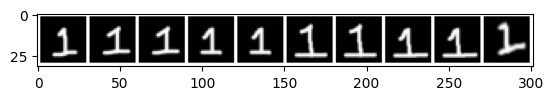

正解ラベル: [2 2 2 2 2 2 2 2 2 2]
予測ラベル: [2 2 2 2 2 2 2 2 2 2] 正解数: 10


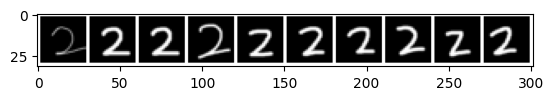

正解ラベル: [2 3 3 3 3 3 3 3 3 3]
予測ラベル: [2 3 3 3 3 3 3 3 3 3] 正解数: 10


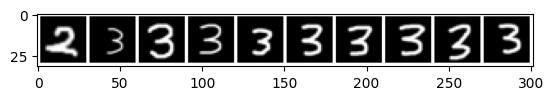

正解ラベル: [3 4 4 4 4 4 4 4 4 4]
予測ラベル: [3 4 4 4 4 4 4 4 4 4] 正解数: 10


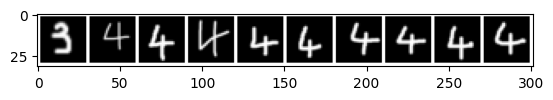

正解ラベル: [4 5 5 5 5 5 5 5 5 5]
予測ラベル: [4 5 5 5 5 5 7 6 5 5] 正解数: 8


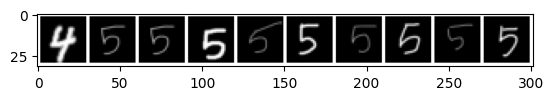

正解ラベル: [5 5 6 6 6 6 6 6 6 6]
予測ラベル: [5 5 0 0 6 6 6 6 1 2] 正解数: 6


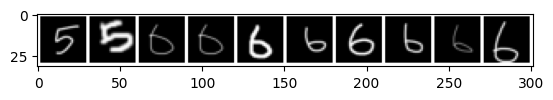

正解ラベル: [6 6 6 7 7 7 7 7 7 7]
予測ラベル: [0 1 6 7 7 7 7 7 7 7] 正解数: 8


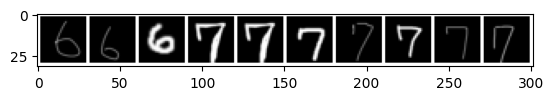

正解ラベル: [7 7 7 7 8 8 8 8 8 8]
予測ラベル: [1 7 7 7 8 8 8 8 8 0] 正解数: 8


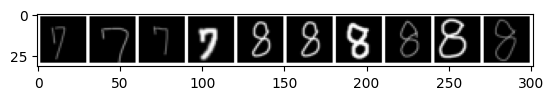

正解ラベル: [8 8 8 8 8 9 9 9 9 9]
予測ラベル: [8 9 8 8 8 9 9 9 9 9] 正解数: 9


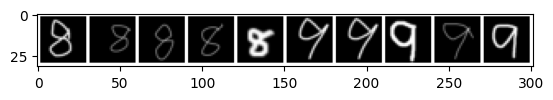

正解ラベル: [9 9 9 9 9 9]
予測ラベル: [9 9 9 9 9 9] 正解数: 6


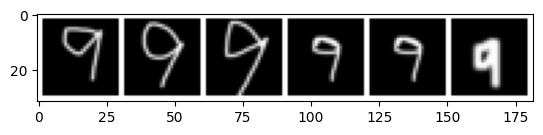

総正解ラベル数/総ラベル数 =104/116
正解率 = 0.896551724137931


In [ ]:
predict_my_dataset(model3)

## [実験内容]

* SoseiExp01.pdf に記載

## [考察の記述]

(ここに考察を記入してください．)<br>

実験結果をもとにして、MLP、CNN、AlexNetの3つのモデルを比較して考察すると以下のようになります。

1. MLP (multilayer perceptron)
   - 正解率が約79.3%と最も低い
   - 単純なニューラルネットワークモデルであり、画像分類に適していないと考えられる

2. CNN (convolutional neural network)
   - 正解率が約81.0%
   - CNNはローカルな特徴量抽出に強いため、画像分類に適しているモデル
   - MLP よりも良い性能を発揮しているが、まだ改善の余地がある

3. AlexNet
   - 正解率が約89.7%と最も高い
   - AlexNetはCNNの代表的なアーキテクチャの1つで、画像分類タスクに優れた性能を発揮する
   - MLP やシンプルなCNNよりも、画像の特徴を十分にキャプチャできていると考えられる


以上から、MNISTデータセットの画像分類においては、CNNやAlexNetといった畳み込みニューラルネットワークが優れた性能を発揮することがわかりました。特にAlexNetは、深層学習モデルの中でも非常に高い精度を達成している。
また、全てのモデルにおいて文字が薄かったり、文字が小さかったりする場合は認識されにくいという結果になった。理由としては、文字が薄いと、白地と文字の明るさの差が小さくなり、コントラストが低下します。低コントラストでは、文字の輪郭が不明瞭になり、特徴を正確に捉えることが難しくなるからであると思をれる。また、低コントラストの画像は、周囲のノイズの影響を受けやすくなり、認識がされにくくなったのだと思われる。
